### Config the model

In [1]:
from langchain_google_genai import ChatGoogleGenerativeAI
model=ChatGoogleGenerativeAI(model='gemini-1.5-flash')
output=model.invoke("hi")
print(output.content)

Hi there! How can I help you today?


### Config the embedding model

In [2]:
from langchain_huggingface import HuggingFaceEmbeddings
embeddings = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en")
len(embeddings.embed_query("hi"))

c:\Users\sunny\anaconda3\envs\agentic_2_base\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\sunny\anaconda3\envs\agentic_2_base\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\sunny\.cache\huggingface\hub\models--BAAI--bge-small-en. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to

384

### Creating the agent

In [12]:
import operator
from typing import List
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from typing import TypedDict, Annotated, Sequence
from langchain_core.messages import BaseMessage
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate, PromptTemplate
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import HumanMessage, AIMessage
from langgraph.graph import StateGraph,END, START
from langchain.output_parsers import PydanticOutputParser
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import FAISS



In [4]:
class TopicSelectionParser(BaseModel):
    Topic:str=Field(description="selected topic")
    Reasoning:str=Field(description='Reasoning behind topic selection')

In [5]:
parser=PydanticOutputParser(pydantic_object=TopicSelectionParser)
parser.get_format_instructions()

'The output should be formatted as a JSON instance that conforms to the JSON schema below.\n\nAs an example, for the schema {"properties": {"foo": {"title": "Foo", "description": "a list of strings", "type": "array", "items": {"type": "string"}}}, "required": ["foo"]}\nthe object {"foo": ["bar", "baz"]} is a well-formatted instance of the schema. The object {"properties": {"foo": ["bar", "baz"]}} is not well-formatted.\n\nHere is the output schema:\n```\n{"properties": {"Topic": {"description": "selected topic", "title": "Topic", "type": "string"}, "Reasoning": {"description": "Reasoning behind topic selection", "title": "Reasoning", "type": "string"}}, "required": ["Topic", "Reasoning"]}\n```'

In [6]:
class AgentState(TypedDict):
    messages: Annotated[Sequence[BaseMessage], operator.add]

In [56]:
def function_1(state:AgentState):
    
    question=state["messages"][-1]
    
    print("Question",question)
    
    template="""
    Your task is to classify the given user query into one of the following related categories: [Constitution,LLM, Latest]. If question is about 
    Indian constitution then Constitution, if question is generic then LLM and if question is about some recent thing which you don't know then Latest.
    Only respond with the category name and nothing else.

    User query: {question}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    
    response = chain.invoke({"question":question})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

In [57]:
def router(state:AgentState):
    print("-> ROUTER ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "constitution" in last_message.lower():
        return "RAG Call"
    elif "latest" in last_message.lower():
        return "WEB Call"
    else:
        return "LLM Call"

In [58]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [37]:
# Load a PDF and validate the page count
file_path = "C:\\Users\\sunny\\OneDrive\\Documents\\Agentic AI Course\\agentic_AI\\RAG Vol 1\\2023050195.pdf"
loader = PyPDFLoader(file_path)
pages = loader.load()

if len(pages) < 200:
    raise ValueError("The PDF must have at least 200 pages.")

#Using semantic chunking with recursive text splitter
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = text_splitter.split_documents(pages)


# Hugging Face embedding
embedding_model = HuggingFaceEmbeddings(model_name="all-MiniLM-L6-v2")

faiss_flat = FAISS.from_documents(chunks, embedding_model)
retriever_flat = faiss_flat.as_retriever()

In [59]:
# RAG Function
def function_2(state:AgentState):
    print("-> RAG Call ->")
    
    question = state["messages"][0]
    
    prompt=PromptTemplate(
        template="""You are an assistant for question-answering tasks. Use the following pieces of retrieved context to answer the question. If you don't know the answer, just say that you don't know. Use three sentences maximum and keep the answer concise.\nQuestion: {question} \nContext: {context} \nAnswer:""",
        
        input_variables=['context', 'question']
    )
    
    rag_chain = (
        {"context": retriever_flat | format_docs, "question": RunnablePassthrough()}
        | prompt
        | model
        | StrOutputParser()
    )
    result = rag_chain.invoke(question)
    return  {"messages": [result]}

In [77]:
# LLM Function
def function_3(state:AgentState):
    print("-> LLM Call ->")
    question = state["messages"][0]
    
    # Normal LLM call
    complete_query = "Answer the follow question with you knowledge of the real world. Following is the user question: " + question
    response = model.invoke(complete_query)
    return {"messages": [response.content]}

In [87]:
from langchain_community.tools import DuckDuckGoSearchRun
def search_fun(state:AgentState):
    search=DuckDuckGoSearchRun()
    result = search.invoke({"query":state["messages"][0]})
    return {"messages": [result]}


In [62]:
def function_4(state:AgentState):
    
    question = state["messages"][0]
    answer=state["messages"][-1]
    
    print("answer",answer)
    
    template="""
    Your task is to check if the response is related to the user question. 
    Only respond with yes or no and nothing else.

    User query: {question}
    response: {answer}
    {format_instructions}
    """
    
    prompt= PromptTemplate(
        template=template,
        input_variable=["question","answer"],
        partial_variables={"format_instructions": parser.get_format_instructions()}
    )
    
    
    chain= prompt | model | parser
    
    response = chain.invoke({"question":question,"answer":answer})
    
    print("Parsed response:", response)
    
    return {"messages": [response.Topic]}

In [67]:
def router_1(state:AgentState):
    print("-> ROUTER_1 ->")
    
    last_message=state["messages"][-1]
    print("last_message:", last_message)
    
    if "yes" in last_message.lower():
        return "yes"
    else:
        return "no"

In [89]:
workflow=StateGraph(AgentState)
workflow.add_node("Supervisor",function_1)
workflow.add_node("RAG",function_2)
workflow.add_node("LLM",function_3)
workflow.add_node("WEB", search_fun)
workflow.add_node("VALIDATION",function_4)
workflow.set_entry_point("Supervisor")

In [90]:
workflow.add_conditional_edges(
    "Supervisor",
    router,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
        "WEB Call": "WEB",
    }
)

In [91]:
workflow.add_edge("RAG","VALIDATION")
workflow.add_edge("LLM","VALIDATION")
workflow.add_edge("WEB","VALIDATION")

workflow.add_conditional_edges(
    "VALIDATION",
    router_1,
    {
        "yes": END,
        "no":"Supervisor"
    }

)

In [92]:
app=workflow.compile()

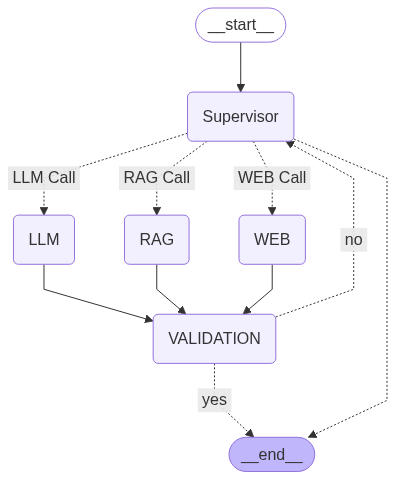

In [93]:
from IPython.display import Image, display
display(Image(app.get_graph(xray=True).draw_mermaid_png()))

In [84]:
state={"messages":["How to make black tea?, list down in simple steps"]}
app.invoke(state)

Question How to make black tea?, list down in simple steps
Parsed response: Topic='LLM' Reasoning='The query is a generic question about making tea, not related to the Indian Constitution or recent events.'
-> ROUTER ->
last_message: LLM
-> LLM Call ->
answer How to Make Black Tea (Simple Steps):

1. **Boil Water:**  Heat water to a rolling boil.  The exact temperature isn't critical for black tea, but generally, boiling is fine.

2. **Warm the Teapot (Optional but recommended):**  Pour a small amount of boiling water into your teapot and swirl it around to preheat.  This helps keep the tea warmer for longer.  Empty the water out.

3. **Add Tea Leaves:** Add 1 teaspoon of loose leaf black tea or 1 tea bag per 6 ounces (177ml) of water to the teapot.  Adjust to your taste; more tea = stronger brew.

4. **Pour Water Over Tea:** Slowly pour the boiling water over the tea leaves or tea bag.

5. **Steep:** Let the tea steep for 3-5 minutes.  Steeping for longer will result in a stronger, mo

{'messages': ['How to make black tea?, list down in simple steps',
  'LLM',
  "How to Make Black Tea (Simple Steps):\n\n1. **Boil Water:**  Heat water to a rolling boil.  The exact temperature isn't critical for black tea, but generally, boiling is fine.\n\n2. **Warm the Teapot (Optional but recommended):**  Pour a small amount of boiling water into your teapot and swirl it around to preheat.  This helps keep the tea warmer for longer.  Empty the water out.\n\n3. **Add Tea Leaves:** Add 1 teaspoon of loose leaf black tea or 1 tea bag per 6 ounces (177ml) of water to the teapot.  Adjust to your taste; more tea = stronger brew.\n\n4. **Pour Water Over Tea:** Slowly pour the boiling water over the tea leaves or tea bag.\n\n5. **Steep:** Let the tea steep for 3-5 minutes.  Steeping for longer will result in a stronger, more bitter tea. Experiment to find your preference.\n\n6. **Remove Tea Leaves/Bag:** Remove the tea bag or strain out the loose leaf tea.\n\n7. **Serve and Enjoy:** Pour th

In [85]:
state={"messages":["List all the fundamental duties?"]}
app.invoke(state)

Question List all the fundamental duties?
Parsed response: Topic='Constitution' Reasoning='The query directly asks about fundamental duties, a key component of the Indian Constitution.'
-> ROUTER ->
last_message: Constitution
-> RAG Call ->
answer The fundamental duties of Indian citizens include abiding by the Constitution and respecting its ideals, cherishing the ideals of the freedom struggle, and upholding India's sovereignty, unity, and integrity.  Additionally, citizens are to defend the country and render national service when called upon.  Further duties include protecting the environment, safeguarding forests and wildlife, and promoting international peace and security.
Parsed response: Topic='yes' Reasoning="The response directly addresses the user's request by listing the fundamental duties."
-> ROUTER_1 ->
last_message: yes


{'messages': ['List all the fundamental duties?',
  'Constitution',
  "The fundamental duties of Indian citizens include abiding by the Constitution and respecting its ideals, cherishing the ideals of the freedom struggle, and upholding India's sovereignty, unity, and integrity.  Additionally, citizens are to defend the country and render national service when called upon.  Further duties include protecting the environment, safeguarding forests and wildlife, and promoting international peace and security.",
  'yes']}

In [96]:
state={"messages":["what is the net worth of Elon Musk"]}
app.invoke(state)

Question what is the net worth of Elon Musk
Parsed response: Topic='Latest' Reasoning="The query asks about Elon Musk's net worth, which is a current event and not directly related to the Indian Constitution or LLMs."
-> ROUTER ->
last_message: Latest


c:\Users\sunny\anaconda3\envs\agentic_2_base\Lib\site-packages\langchain_community\utilities\duckduckgo_search.py:64: UserWarning: backend='api' is deprecated, using backend='auto'
  ddgs_gen = ddgs.text(


answer Tesla shares fell after Elon Musk's public disagreement with the president. Musk's net worth, though still the world's highest, has fluctuated significantly, peaking at $400 billion in December 2024. Elon Musk on the 2025 The Richest Person In Every State. ... Elon Musk's net worth fell by the equivalent of almost five times Trump's $5.5 billion net worth Thursday. Elon Musk remains the world's richest person in 2025 with a net worth of $369 billion, according to Benzinga. The Tesla CEO holds his standing, even after a $63.5 billion year-to-date drop in ... Elon Musk's net worth peaked at $486 billion in December 2024, but by March 2025, his fortune had decreased to approximately $330 billion. The market capitalization of Tesla's stock fell from ... Elon Musk is a South African-born Canadian-American businessman, inventor, and investor who has a net worth of $368 billion. Elon Musk is currently the richest person in the world. In November ...
Parsed response: Topic='yes' Reasoni

{'messages': ['what is the net worth of Elon Musk',
  'Latest',
  "Tesla shares fell after Elon Musk's public disagreement with the president. Musk's net worth, though still the world's highest, has fluctuated significantly, peaking at $400 billion in December 2024. Elon Musk on the 2025 The Richest Person In Every State. ... Elon Musk's net worth fell by the equivalent of almost five times Trump's $5.5 billion net worth Thursday. Elon Musk remains the world's richest person in 2025 with a net worth of $369 billion, according to Benzinga. The Tesla CEO holds his standing, even after a $63.5 billion year-to-date drop in ... Elon Musk's net worth peaked at $486 billion in December 2024, but by March 2025, his fortune had decreased to approximately $330 billion. The market capitalization of Tesla's stock fell from ... Elon Musk is a South African-born Canadian-American businessman, inventor, and investor who has a net worth of $368 billion. Elon Musk is currently the richest person in the